In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('CAR DETAILS.csv')

### Data Preprocessing
a. Handle Null Values

In [3]:
# Check for null values
df.isnull().sum()


name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64

b. Handle Duplicate Values

In [4]:
# Check for duplicate rows
df.duplicated().sum()

763

In [5]:
df.shape

(4340, 8)

In [6]:
# Drop duplicates
df = df.drop_duplicates()

In [7]:
df.shape

(3577, 8)

3. Check Data Types

In [8]:
# Check data types of columns
df.dtypes

name             object
year              int64
selling_price     int64
km_driven         int64
fuel             object
seller_type      object
transmission     object
owner            object
dtype: object

d. Data Consistency

In [9]:
# Check for inconsistencies like negative values in 'km_driven' or 'selling_price'
df.describe()

# Ensure all categorical columns have valid entries
print(df['fuel'].unique())  # Example for fuel type

['Petrol' 'Diesel' 'CNG' 'LPG' 'Electric']


e. Outlier Treatment

In [10]:
def clip_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Apply outlier clipping to relevant columns
df = clip_outliers(df, 'km_driven')
df = clip_outliers(df, 'selling_price')

In [11]:
df.shape

(3577, 8)

f. Feature Engineering - Brand and Model

In [12]:
# Split 'name' column into 'brand' and 'model'
df['brand'] = df['name'].str.split(' ', expand=True)[0]

# Group less frequent brands into 'Other'
brand_counts = df['brand'].value_counts()
df['brand'] = df['brand'].apply(lambda x: 'Other' if brand_counts[x] < 100 else x)

# Drop the 'name' column as it's no longer needed
df = df.drop(columns=['name'])

In [13]:
df.shape

(3577, 8)

In [14]:
df['brand'].value_counts()

brand
Maruti       1072
Hyundai       637
Other         365
Mahindra      328
Tata          308
Ford          220
Honda         216
Toyota        170
Chevrolet     151
Renault       110
Name: count, dtype: int64

g. Encoding - Ordinal Encoding

In [15]:
df = pd.get_dummies(df, columns=['brand', 'fuel', 'seller_type', 'transmission', 'owner'], drop_first=True)

h. Scaling 

In [16]:
from sklearn.preprocessing import StandardScaler

# Apply scaling after splitting brand and model
#scaler = StandardScaler()
#df[['km_driven', 'selling_price']] = scaler.fit_transform(df[['km_driven', 'selling_price']])


In [17]:
# Save the scaler
#pickle.dump(scaler, open('target_scaler.pkl', 'wb'))

In [18]:
### Changed Scaling
from sklearn.preprocessing import StandardScaler
import pickle
# Apply scaling
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Fit feature scaler and transform
df[['km_driven']] = feature_scaler.fit_transform(df[['km_driven']])

# Fit target scaler and transform
df[['selling_price']] = target_scaler.fit_transform(df[['selling_price']])

# Save the scalers
pickle.dump(feature_scaler, open('feature_scaler.pkl', 'wb'))
pickle.dump(target_scaler, open('target_scaler.pkl', 'wb'))


### Exploratory Data Analysis (EDA)
a. Univariate and Bivariate Analysis

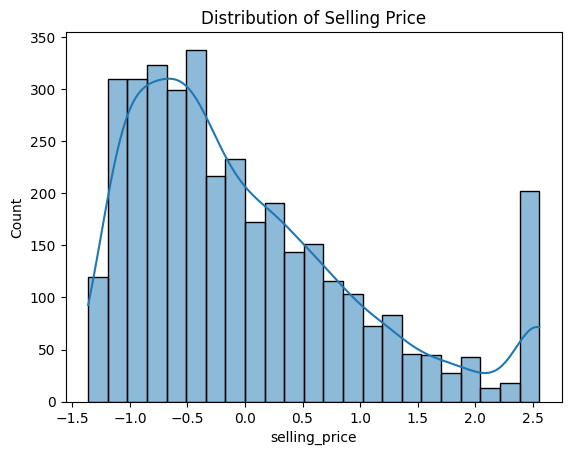

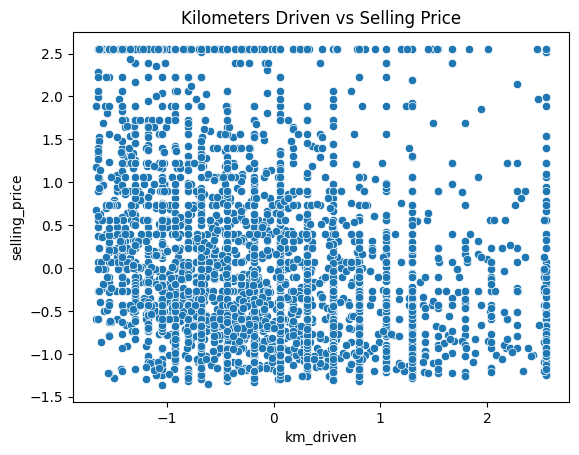

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Univariate Analysis: Distribution of 'selling_price'
sns.histplot(df['selling_price'], kde=True)
plt.title('Distribution of Selling Price')
plt.show()

# Bivariate Analysis: 'km_driven' vs 'selling_price'
sns.scatterplot(x='km_driven', y='selling_price', data=df)
plt.title('Kilometers Driven vs Selling Price')
plt.show()


In [20]:
# Example: Capping outliers for 'km_driven'
df['km_driven'] = np.clip(df['km_driven'], df['km_driven'].quantile(0.01), df['km_driven'].quantile(0.99))


### Regression Models, Baggin, Ensemble Techniques
a. Model Building

In [21]:
# Assuming 'selling_price' is the target
X = df.drop(columns=['selling_price'])
y = df['selling_price']


In [22]:
#### Model Training
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import pickle

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models and train
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'KNN Regressor': KNeighborsRegressor(),
    'Random Forest': RandomForestRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'XGBoost': XGBRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print(f"{name}: {score}")


Linear Regression: 0.6478816135352936
Ridge Regression: 0.6479190306664775
Lasso Regression: 0.31344838179455314
Decision Tree: 0.49174024845535214
KNN Regressor: 0.6719483258086243
Random Forest: 0.6967086432625527
AdaBoost: 0.5795113738380419
XGBoost: 0.6901858973172367


In [23]:
# Assuming X_train is the feature matrix after one-hot encoding
model_columns = X_train.columns

# Save the columns to a file
pickle.dump(model_columns, open('model_columns.pkl', 'wb'))

In [24]:
### Hyper parameter tuning for Random Forest
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Output the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

# Use the best model for predictions
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluate the model performance
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test R^2 Score: {r2}")
print(f"Test Mean Squared Error: {mse}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\riamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
144 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\riamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\riamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\riamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\bas

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best Score: 0.7087023552793401
Test R^2 Score: 0.7242768588757498
Test Mean Squared Error: 0.28189765119175


In [25]:
#### Model Retrain
# Retrain the model using the best parameters
best_rf = RandomForestRegressor(
    max_depth=20, 
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=10, 
    n_estimators=300,
    random_state=42
)
best_rf.fit(X_train, y_train)

# Save the retrained model
import pickle
with open('best_rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
